# CostGrow Downscaling (Inference-Style)

Standalone notebook organized to match `inference.html` flow:
1. input checks
2. raw-input plots
3. validation preprocessing
4. CostGrow inference
5. bilinear-baseline comparison with modelz-adapted metrics
6. final diagnostics and export


## 1) Imports


In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import rasterio
from rasterio.warp import Resampling, reproject

from skimage.graph import MCP_Geometric
from skimage.measure import label
from skimage.metrics import structural_similarity


## 2) Inputs And Controls


In [2]:
# Input rasters
input_hires_dem_fp = Path("tests/data/bryantTechnicalNoteResolution2024/dem_04m.tif")
input_lores_wse_fp = Path("tests/data/bryantTechnicalNoteResolution2024/wse_32m.tif")
valid_hires_wse_fp = Path("tests/data/bryantTechnicalNoteResolution2024/wse_04m.tif")

# Output raster
output_wse_fp = input_hires_dem_fp.with_name("wse_downscaled_costgrow_inference_style.tif")

# CostGrow controls
max_grow_coarse_pixels = 10
terrain_penalty_scale = 1.0
decay_per_meter = 0.0

# Validation thresholds in meters (adapted from modelz.py)
RMSE_WET_THRESH_M = 0.5
CSI_THRESH_M = 0.01
DRY_DEPTH_THRESH_M = CSI_THRESH_M

for fp_name, fp in {
    "High-res DEM": input_hires_dem_fp,
    "Low-res WSE": input_lores_wse_fp,
    "Validation high-res WSE": valid_hires_wse_fp,
}.items():
    if not fp.exists():
        raise FileNotFoundError(f"{fp_name} not found: {fp}")


## 3) Raster I/O, Plotting, And Metrics Helpers


In [3]:
def read_raster(fp):
    """Read a single-band raster to float64 and convert nodata to NaN."""
    # Read with a mask first so nodata is preserved and normalized to NaN.
    with rasterio.open(fp) as src:
        arr = src.read(1, masked=True).astype("float64").filled(np.nan)
        profile = src.profile.copy()
    return arr, profile


def reproject_to_match(src_arr, src_profile, dst_profile, resampling):
    """Reproject `src_arr` into `dst_profile` grid using the requested resampling."""
    # Use explicit nodata sentinels so rasterio can safely carry missing values.
    src_nodata = -9999.0
    dst_nodata = -9999.0

    src_clean = np.where(np.isfinite(src_arr), src_arr, src_nodata).astype("float64")
    dst = np.full((dst_profile["height"], dst_profile["width"]), dst_nodata, dtype="float64")

    reproject(
        source=src_clean,
        destination=dst,
        src_transform=src_profile["transform"],
        src_crs=src_profile["crs"],
        src_nodata=src_nodata,
        dst_transform=dst_profile["transform"],
        dst_crs=dst_profile["crs"],
        dst_nodata=dst_nodata,
        resampling=resampling,
    )

    # Convert the sentinel back to NaN for downstream NumPy math.
    dst[dst == dst_nodata] = np.nan
    return dst


def reproject_valid_mask(src_arr, src_profile, dst_profile):
    """Reproject finite-value mask from source grid onto destination grid."""
    # Convert source finite pixels to a binary mask and map with nearest-neighbor.
    src_mask = np.isfinite(src_arr).astype("uint8")
    dst_mask = np.zeros((dst_profile["height"], dst_profile["width"]), dtype="uint8")

    reproject(
        source=src_mask,
        destination=dst_mask,
        src_transform=src_profile["transform"],
        src_crs=src_profile["crs"],
        src_nodata=0,
        dst_transform=dst_profile["transform"],
        dst_crs=dst_profile["crs"],
        dst_nodata=0,
        resampling=Resampling.nearest,
    )
    return dst_mask.astype(bool)


def _assert_bounds_close(bounds_a, bounds_b, name_a, name_b, tol=1e-6):
    """Raise if two raster bounds differ beyond tolerance."""
    # Compare each bound component so the error message can stay explicit.
    if not all(np.isclose(a, b, atol=tol) for a, b in zip(bounds_a, bounds_b)):
        raise ValueError(f"{name_a} bounds {bounds_a} != {name_b} bounds {bounds_b}")


def assert_profiles_compatible(dem_profile, lores_wse_profile, valid_wse_profile):
    """Validate CRS/extent consistency between DEM, low-res WSE, and validation WSE."""
    # DEM and validation WSE must be on the same final analysis grid.
    if dem_profile["crs"] != valid_wse_profile["crs"]:
        raise ValueError("DEM and validation WSE CRS must match.")
    if dem_profile["transform"] != valid_wse_profile["transform"]:
        raise ValueError("DEM and validation WSE transforms must match.")
    if dem_profile["height"] != valid_wse_profile["height"] or dem_profile["width"] != valid_wse_profile["width"]:
        raise ValueError("DEM and validation WSE dimensions must match.")

    # Low-res WSE can differ in resolution but should share CRS and bounds.
    if dem_profile["crs"] != lores_wse_profile["crs"]:
        raise ValueError("DEM and low-res WSE CRS must match.")

    dem_bounds = rasterio.transform.array_bounds(
        dem_profile["height"],
        dem_profile["width"],
        dem_profile["transform"],
    )
    lowres_bounds = rasterio.transform.array_bounds(
        lores_wse_profile["height"],
        lores_wse_profile["width"],
        lores_wse_profile["transform"],
    )
    _assert_bounds_close(dem_bounds, lowres_bounds, "DEM", "low-res WSE")


def mcp_distance(seed_mask, domain_mask):
    """Compute least-cost distance from seed cells across the allowed domain."""
    # Restrict seeds to valid domain cells before solving the MCP graph.
    valid_seeds = seed_mask & domain_mask
    if not np.any(valid_seeds):
        raise ValueError("No valid seed cells available for MCP distance.")

    cost = np.ones(seed_mask.shape, dtype="float64")
    cost[~domain_mask] = np.inf

    mcp = MCP_Geometric(cost, fully_connected=True)
    cumulative_costs, _ = mcp.find_costs(starts=np.argwhere(valid_seeds))
    return cumulative_costs


# def mcp_fill(seed_values, seed_mask, cost_surface, domain_mask, target_mask=None):
#     """Propagate seed values to target cells along least-cost MCP paths."""
#     # Validate that at least one seed exists in the reachable domain.
#     valid_seeds = seed_mask & domain_mask
#     if not np.any(valid_seeds):
#         raise ValueError("No valid seed cells available for MCP fill.")
#
#     # Clip the cost surface to the valid domain to block nodata traversal.
#     cost = cost_surface.astype("float64").copy()
#     cost[~domain_mask] = np.inf
#
#     mcp = MCP_Geometric(cost, fully_connected=True)
#     cumulative_costs, _ = mcp.find_costs(starts=np.argwhere(valid_seeds))
#
#     # If no explicit target mask is given, fill every non-seed domain cell.
#     if target_mask is None:
#         target_mask = domain_mask & ~valid_seeds
#     else:
#         target_mask = target_mask & domain_mask & ~valid_seeds
#
#     filled = seed_values.copy()
#
#     # Trace each target back to its source seed and copy the source value.
#     for r, c in np.argwhere(target_mask):
#         if not np.isfinite(cumulative_costs[r, c]):
#             continue
#         src_r, src_c = mcp.traceback((r, c))[0]
#         filled[r, c] = seed_values[src_r, src_c]
#
#     return filled, cumulative_costs


def mcp_fill_fast(seed_values, seed_mask, cost_surface, domain_mask, target_mask=None):
    """Propagate seed values along MCP paths using traceback-index caching."""
    # Validate that at least one seed exists in the reachable domain.
    valid_seeds = seed_mask & domain_mask
    if not np.any(valid_seeds):
        raise ValueError("No valid seed cells available for MCP fill.")

    # Clip the cost surface to the valid domain to block nodata traversal.
    cost = cost_surface.astype("float64").copy()
    cost[~domain_mask] = np.inf

    mcp = MCP_Geometric(cost, fully_connected=True)
    cumulative_costs, traceback_idx = mcp.find_costs(starts=np.argwhere(valid_seeds))

    # If no explicit target mask is given, fill every non-seed domain cell.
    if target_mask is None:
        target_mask = domain_mask & ~valid_seeds
    else:
        target_mask = target_mask & domain_mask & ~valid_seeds

    filled = seed_values.copy()

    # Cache resolved source seeds so shared path segments are traced once.
    source_r = np.full(seed_mask.shape, -1, dtype=np.int32)
    source_c = np.full(seed_mask.shape, -1, dtype=np.int32)
    seed_rows, seed_cols = np.nonzero(valid_seeds)
    source_r[seed_rows, seed_cols] = seed_rows
    source_c[seed_rows, seed_cols] = seed_cols

    offsets = np.asarray(mcp.offsets, dtype=np.int16)
    nrows, ncols = seed_mask.shape

    for start_r, start_c in np.argwhere(target_mask):
        if not np.isfinite(cumulative_costs[start_r, start_c]):
            continue

        r, c = int(start_r), int(start_c)
        trail = []

        while source_r[r, c] < 0:
            tb_idx = int(traceback_idx[r, c])
            if tb_idx < 0:
                break

            dr, dc = offsets[tb_idx]
            nr, nc = r - int(dr), c - int(dc)
            if nr < 0 or nr >= nrows or nc < 0 or nc >= ncols:
                break

            trail.append((r, c))
            r, c = nr, nc

        src_r = int(source_r[r, c])
        src_c = int(source_c[r, c])
        if src_r < 0:
            continue

        filled[start_r, start_c] = seed_values[src_r, src_c]

        for pr, pc in trail:
            source_r[pr, pc] = src_r
            source_c[pr, pc] = src_c

    return filled, cumulative_costs


# Use the faster fill implementation for all downstream notebook cells.
mcp_fill = mcp_fill_fast

def keep_components_connected_to_anchor(wet_mask, anchor_mask):
    """Keep only wet components that are connected to anchor wet cells."""
    # Label wet connected components and preserve those touching anchors.
    labels = label(wet_mask.astype("uint8"), connectivity=1)
    keep_labels = np.unique(labels[anchor_mask & wet_mask])
    keep_labels = keep_labels[keep_labels != 0]
    return np.isin(labels, keep_labels) & wet_mask


def wse_to_depth_m(wse_arr, dem_arr, domain_mask):
    """Convert WSE to depth in meters, treating NaN WSE as dry depth=0 inside domain."""
    # Start with NaN everywhere, then populate only where the DEM domain is valid.
    depth = np.full_like(dem_arr, np.nan, dtype="float64")
    if not np.any(domain_mask):
        return depth

    # Use 0 m for dry (NaN WSE) cells and clamp negative depth to zero.
    wse_filled = np.where(np.isfinite(wse_arr), wse_arr, dem_arr)
    depth_local = np.maximum(wse_filled - dem_arr, 0.0)
    depth[domain_mask] = depth_local[domain_mask]
    return depth


def plot_hist_raster_grid(plot_specs, title, bins=60):
    """Plot inference-style histogram+raster diagnostics for each input array."""
    # Build a two-column layout: histogram on the left, raster on the right.
    fig, axes = plt.subplots(nrows=len(plot_specs), ncols=2, figsize=(10, 4 * len(plot_specs)))
    if len(plot_specs) == 1:
        axes = np.array([axes])

    for row_idx, (name, arr, cmap, use_dry_mask, dry_thresh) in enumerate(plot_specs):
        # Extract finite values for robust stats and histogram generation.
        arr = np.asarray(arr)
        vals = arr[np.isfinite(arr)]

        ax_hist = axes[row_idx, 0]
        ax_raster = axes[row_idx, 1]

        if vals.size:
            ax_hist.hist(vals, bins=bins, color="steelblue", alpha=0.9)
            if use_dry_mask and dry_thresh is not None:
                ax_hist.axvline(dry_thresh, color="red", linestyle="--", linewidth=1.5)
            stat_text = (
                f"shape: {arr.shape}\n"
                f"min: {vals.min():.3f}\n"
                f"max: {vals.max():.3f}\n"
                f"mean: {vals.mean():.3f}\n"
                f"std: {vals.std():.3f}"
            )
        else:
            stat_text = f"shape: {arr.shape}\n(no finite values)"

        ax_hist.set_title(f"{name} histogram")
        ax_hist.set_xlabel("Value")
        ax_hist.set_ylabel("Count")
        ax_hist.grid(color="lightgrey", linestyle="-", linewidth=0.7)
        ax_hist.text(
            0.98,
            0.95,
            stat_text,
            transform=ax_hist.transAxes,
            fontsize=9,
            va="top",
            ha="right",
        )

        # Optionally hide dry cells in map view to emphasize wet structure.
        if use_dry_mask and dry_thresh is not None:
            raster_arr = np.ma.masked_where(arr < dry_thresh, arr)
        else:
            raster_arr = arr

        im = ax_raster.imshow(raster_arr, cmap=cmap)
        ax_raster.set_title(f"{name} raster")
        ax_raster.set_axis_off()
        fig.colorbar(im, ax=ax_raster, fraction=0.046, pad=0.04)

    fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()


def _shared_valid_mask(obs_arr, pred_arr, domain_mask):
    """Return pixels that are finite in both arrays and inside the domain."""
    # Keep metrics on a shared valid support to avoid denominator drift.
    return domain_mask & np.isfinite(obs_arr) & np.isfinite(pred_arr)


def metric_psnr(obs_arr, pred_arr, domain_mask):
    """Compute PSNR on domain-valid pixels."""
    # Compute error only where both fields are valid.
    valid = _shared_valid_mask(obs_arr, pred_arr, domain_mask)
    if not np.any(valid):
        return np.nan

    mse = float(np.mean((pred_arr[valid] - obs_arr[valid]) ** 2))
    if np.isclose(mse, 0.0):
        return np.inf

    max_val = float(np.max(obs_arr[valid]))
    if max_val <= 0.0:
        max_val = 1.0
    return float(20.0 * np.log10(max_val) - 10.0 * np.log10(mse))


def metric_ssim(obs_arr, pred_arr, domain_mask):
    """Compute SSIM on domain-valid pixels using masked zero-fill outside domain."""
    # Restrict dynamic range computation to valid support.
    valid = _shared_valid_mask(obs_arr, pred_arr, domain_mask)
    if np.count_nonzero(valid) < 9:
        return np.nan

    obs_img = np.where(valid, obs_arr, 0.0)
    pred_img = np.where(valid, pred_arr, 0.0)

    obs_valid = obs_arr[valid]
    data_range = float(obs_valid.max() - obs_valid.min())
    if data_range <= 0.0:
        data_range = 1.0

    return float(structural_similarity(obs_img, pred_img, data_range=data_range))


def metric_rmse(obs_arr, pred_arr, domain_mask):
    """Compute RMSE on domain-valid pixels."""
    # Use a shared finite mask to align obs and prediction samples.
    valid = _shared_valid_mask(obs_arr, pred_arr, domain_mask)
    if not np.any(valid):
        return np.nan
    return float(np.sqrt(np.mean((pred_arr[valid] - obs_arr[valid]) ** 2)))


def metric_rmse_wet(obs_arr, pred_arr, domain_mask, threshold_m):
    """Compute RMSE only on wet observed pixels (obs > threshold)."""
    # Follow modelz.py semantics by filtering on wet observed pixels.
    valid = _shared_valid_mask(obs_arr, pred_arr, domain_mask)
    wet = valid & (obs_arr > threshold_m)
    if not np.any(wet):
        return np.nan
    return float(np.sqrt(np.mean((pred_arr[wet] - obs_arr[wet]) ** 2)))


def metric_csi(obs_arr, pred_arr, domain_mask, threshold_m):
    """Compute Critical Success Index for wet/dry classification at threshold."""
    # Build binary wet masks over valid pixels.
    valid = _shared_valid_mask(obs_arr, pred_arr, domain_mask)
    if not np.any(valid):
        return np.nan

    obs_wet = obs_arr[valid] >= threshold_m
    pred_wet = pred_arr[valid] >= threshold_m

    tp = np.sum(pred_wet & obs_wet)
    fp = np.sum(pred_wet & ~obs_wet)
    fn = np.sum(~pred_wet & obs_wet)
    denom = tp + fp + fn

    if denom == 0:
        return np.nan
    return float(tp / denom)


def compute_validation_metrics(obs_depth_m, pred_depth_m, domain_mask, wet_thresh_m, csi_thresh_m):
    """Compute modelz-adapted validation metrics for one predicted depth raster."""
    # Derive a single shared mask for all summary calculations.
    valid = _shared_valid_mask(obs_depth_m, pred_depth_m, domain_mask)
    if not np.any(valid):
        return {
            "psnr": np.nan,
            "ssim": np.nan,
            "rmse_m": np.nan,
            "rmse_wet_m": np.nan,
            "csi": np.nan,
            "mae_m": np.nan,
            "bias_m": np.nan,
            "obs_wet_fraction": np.nan,
            "pred_wet_fraction": np.nan,
            "valid_pixel_count": 0,
        }

    obs_vals = obs_depth_m[valid]
    pred_vals = pred_depth_m[valid]

    # Compute base error metrics in depth units (meters).
    mae_m = float(np.mean(np.abs(pred_vals - obs_vals)))
    bias_m = float(np.mean(pred_vals - obs_vals))

    return {
        "psnr": metric_psnr(obs_depth_m, pred_depth_m, domain_mask),
        "ssim": metric_ssim(obs_depth_m, pred_depth_m, domain_mask),
        "rmse_m": metric_rmse(obs_depth_m, pred_depth_m, domain_mask),
        "rmse_wet_m": metric_rmse_wet(obs_depth_m, pred_depth_m, domain_mask, threshold_m=wet_thresh_m),
        "csi": metric_csi(obs_depth_m, pred_depth_m, domain_mask, threshold_m=csi_thresh_m),
        "mae_m": mae_m,
        "bias_m": bias_m,
        "obs_wet_fraction": float(np.mean(obs_vals >= csi_thresh_m)),
        "pred_wet_fraction": float(np.mean(pred_vals >= csi_thresh_m)),
        "valid_pixel_count": int(valid.sum()),
    }


## 4) Load Rasters And Run Input Checks


In [4]:
hires_dem, dem_profile = read_raster(input_hires_dem_fp)
lores_wse, wse_profile = read_raster(input_lores_wse_fp)
valid_hires_wse, valid_profile = read_raster(valid_hires_wse_fp)

assert_profiles_compatible(
    dem_profile=dem_profile,
    lores_wse_profile=wse_profile,
    valid_wse_profile=valid_profile,
)

dem_valid = np.isfinite(hires_dem)
if not np.any(dem_valid):
    raise ValueError("DEM has no valid pixels.")

print("Input summary")
print(f"  DEM shape/res: {hires_dem.shape}, {dem_profile['transform'].a} m")
print(f"  LR WSE shape/res: {lores_wse.shape}, {wse_profile['transform'].a} m")
print(f"  HR validation WSE shape/res: {valid_hires_wse.shape}, {valid_profile['transform'].a} m")


Input summary
  DEM shape/res: (1664, 3360), 4.0 m
  LR WSE shape/res: (208, 420), 32.0 m
  HR validation WSE shape/res: (1664, 3360), 4.0 m


## 5) Plot Raw Inputs


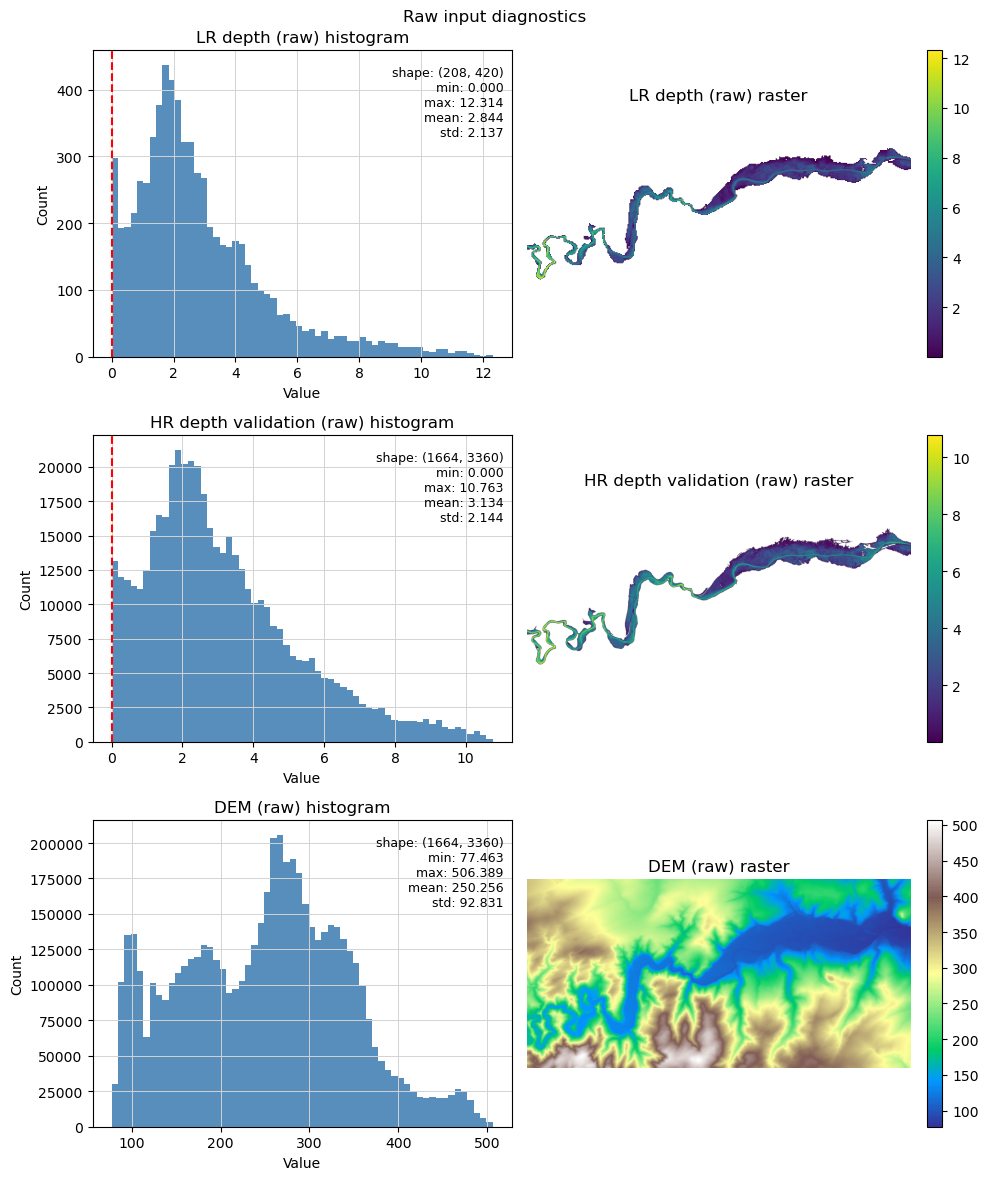

In [5]:
# Reproject DEM to the low-res grid so low-res depth can be inspected directly.
dem_on_lores = reproject_to_match(
    hires_dem,
    dem_profile,
    wse_profile,
    resampling=Resampling.bilinear,
)

# Raw low-res depth (meters), with NaN where either DEM or WSE is missing.
lores_depth_raw = np.where(
    np.isfinite(lores_wse) & np.isfinite(dem_on_lores),
    np.maximum(lores_wse - dem_on_lores, 0.0),
    np.nan,
)

# Raw high-res validation depth (meters).
valid_depth_raw = np.where(
    np.isfinite(valid_hires_wse) & dem_valid,
    np.maximum(valid_hires_wse - hires_dem, 0.0),
    np.nan,
)

plot_specs_raw = [
    ("LR depth (raw)", lores_depth_raw, "viridis", True, DRY_DEPTH_THRESH_M),
    ("HR depth validation (raw)", valid_depth_raw, "viridis", True, DRY_DEPTH_THRESH_M),
    ("DEM (raw)", hires_dem, "terrain", False, None),
]

plot_hist_raster_grid(
    plot_specs=plot_specs_raw,
    title="Raw input diagnostics",
    bins=60,
)


## 6) Pre-Process Validation Raster And Build Bilinear Baseline


In [6]:
# Bilinear baseline in WSE space (direct upsampling from low-res WSE).
wse_bilinear = reproject_to_match(
    lores_wse,
    wse_profile,
    dem_profile,
    resampling=Resampling.bilinear,
)
wse_bilinear[~dem_valid] = np.nan

# Convert to depth with dry handling that matches evaluation assumptions.
valid_depth = wse_to_depth_m(valid_hires_wse, hires_dem, dem_valid)
bilinear_depth = wse_to_depth_m(wse_bilinear, hires_dem, dem_valid)

print("Prepared validation arrays")
print(f"  valid_depth shape: {valid_depth.shape}")
print(f"  bilinear_depth shape: {bilinear_depth.shape}")


Prepared validation arrays
  valid_depth shape: (1664, 3360)
  bilinear_depth shape: (1664, 3360)


## 8) CostGrow Inference (No Windowing/Chips)


In [7]:
# 01: Resample low-res WSE to high-res DEM grid for phase-2 wet anchors.
wse_fine_resampled = reproject_to_match(
    lores_wse,
    wse_profile,
    dem_profile,
    resampling=Resampling.bilinear,
)
resampled_valid = reproject_valid_mask(lores_wse, wse_profile, dem_profile)
wse_fine_resampled[~resampled_valid] = np.nan
wse_fine_resampled[~dem_valid] = np.nan


In [8]:

# 02: Keep wet partials where WSE is above terrain.
wse_wet_partials = wse_fine_resampled.copy()
wse_wet_partials[wse_wet_partials <= hires_dem] = np.nan
anchor_mask = np.isfinite(wse_wet_partials)

if not np.any(anchor_mask):
    raise ValueError("No wet cells remain after applying WSE > DEM.")


In [9]:

# Approximate coarse-to-fine scale ratio in pixel units.
fine_pixel_size = float(np.mean([abs(dem_profile["transform"].a), abs(dem_profile["transform"].e)]))
coarse_pixel_size = float(np.mean([abs(wse_profile["transform"].a), abs(wse_profile["transform"].e)]))
downscale = max(1, int(round(coarse_pixel_size / fine_pixel_size)))
max_grow_fine_pixels = max_grow_coarse_pixels * downscale


In [10]:

# Fill low-res resample neutrally to create a terrain-penalty reference surface.
neutral_seed_mask = np.isfinite(wse_fine_resampled)
neutral_seed_values = np.where(neutral_seed_mask, wse_fine_resampled, np.nan)
wse_neutral_filled, _ = mcp_fill(
    seed_values=neutral_seed_values,
    seed_mask=neutral_seed_mask,
    cost_surface=np.ones_like(hires_dem, dtype="float64"),
    domain_mask=dem_valid,
)


In [11]:

# Build terrain-penalized cost: greater penalty where filled WSE is below DEM.
delta = wse_neutral_filled - hires_dem
cost_surface = np.where(delta > 0.0, 1.0, 1.0 + np.abs(delta) * terrain_penalty_scale)
cost_surface[~dem_valid] = np.inf


In [12]:

# 03: Growth distance threshold (in fine pixels).
distance_pixels = mcp_distance(anchor_mask, dem_valid)
grow_mask = np.isfinite(distance_pixels) & (distance_pixels <= max_grow_fine_pixels)


In [13]:

# Propagate anchor WSE values with terrain-penalized MCP fill.
wse_seed_values = np.where(anchor_mask, wse_wet_partials, np.nan)
wse_grown, _ = mcp_fill(
    seed_values=wse_seed_values,
    seed_mask=anchor_mask,
    cost_surface=cost_surface,
    domain_mask=dem_valid,
    target_mask=grow_mask,
)


In [14]:

# Optional linear decay with travel distance.
decay = distance_pixels * fine_pixel_size * decay_per_meter
wse_grown = wse_grown - np.where(np.isfinite(decay), decay, 0.0)

# Merge growth into phase-2 wet partials where final WSE stays above ground.
wse_costgrow = wse_wet_partials.copy()
add_mask = (~anchor_mask) & grow_mask & np.isfinite(wse_grown) & (wse_grown > hires_dem)
wse_costgrow[add_mask] = wse_grown[add_mask]


In [15]:

# 04: Remove isolated wet blobs that are disconnected from original anchors.
wet_mask_post = np.isfinite(wse_costgrow)
keep_mask = keep_components_connected_to_anchor(wet_mask_post, anchor_mask)
wse_costgrow[~keep_mask] = np.nan
wse_costgrow[~dem_valid] = np.nan


In [16]:

# Convert prediction to depth for validation metrics.
costgrow_depth = wse_to_depth_m(wse_costgrow, hires_dem, dem_valid)

print(f"anchors: {anchor_mask.sum():,}")
print(f"grown cells added: {add_mask.sum():,}")
print(f"final wet cells: {np.isfinite(wse_costgrow).sum():,}")


anchors: 425,253
grown cells added: 25,467
final wet cells: 448,640


## 9) Bilinear Baseline + Validation Metrics (Modelz-Adapted)


In [17]:
# Compute full-scene metrics for CostGrow and bilinear against validation depth.
metrics_costgrow = compute_validation_metrics(
    obs_depth_m=valid_depth,
    pred_depth_m=costgrow_depth,
    domain_mask=dem_valid,
    wet_thresh_m=RMSE_WET_THRESH_M,
    csi_thresh_m=CSI_THRESH_M,
)

metrics_bilinear = compute_validation_metrics(
    obs_depth_m=valid_depth,
    pred_depth_m=bilinear_depth,
    domain_mask=dem_valid,
    wet_thresh_m=RMSE_WET_THRESH_M,
    csi_thresh_m=CSI_THRESH_M,
)

metric_order = [
    "psnr",
    "ssim",
    "rmse_m",
    "rmse_wet_m",
    "csi",
    "mae_m",
    "bias_m",
    "obs_wet_fraction",
    "pred_wet_fraction",
    "valid_pixel_count",
]

metrics_df = pd.DataFrame(
    {
        "CostGrow": metrics_costgrow,
        "Bilinear": metrics_bilinear,
    }
)

metrics_df = metrics_df.loc[metric_order, ["CostGrow", "Bilinear"]]
metrics_df["Delta_CostGrow_minus_Bilinear"] = metrics_df["CostGrow"] - metrics_df["Bilinear"]

print("Full-scene validation metrics")
metrics_df.round(6)


Full-scene validation metrics


,CostGrow,Bilinear,Delta_CostGrow_minus_Bilinear
psnr,3.459459e+01,3.241290e+01,2.181686
ssim,9.903830e-01,9.854510e-01,0.004932
rmse_m,2.005410e-01,2.578030e-01,-0.057262
rmse_wet_m,6.851150e-01,9.021150e-01,-0.216999
csi,9.309920e-01,8.924870e-01,0.038505
mae_m,4.421300e-02,4.928200e-02,-0.005069
bias_m,-2.209700e-02,-2.949000e-02,0.007393
obs_wet_fraction,8.451200e-02,8.451200e-02,0.000000
pred_wet_fraction,8.010600e-02,7.599000e-02,0.004116
valid_pixel_count,5.591040e+06,5.591040e+06,0.000000


## 10) Inference-Style Final Plots


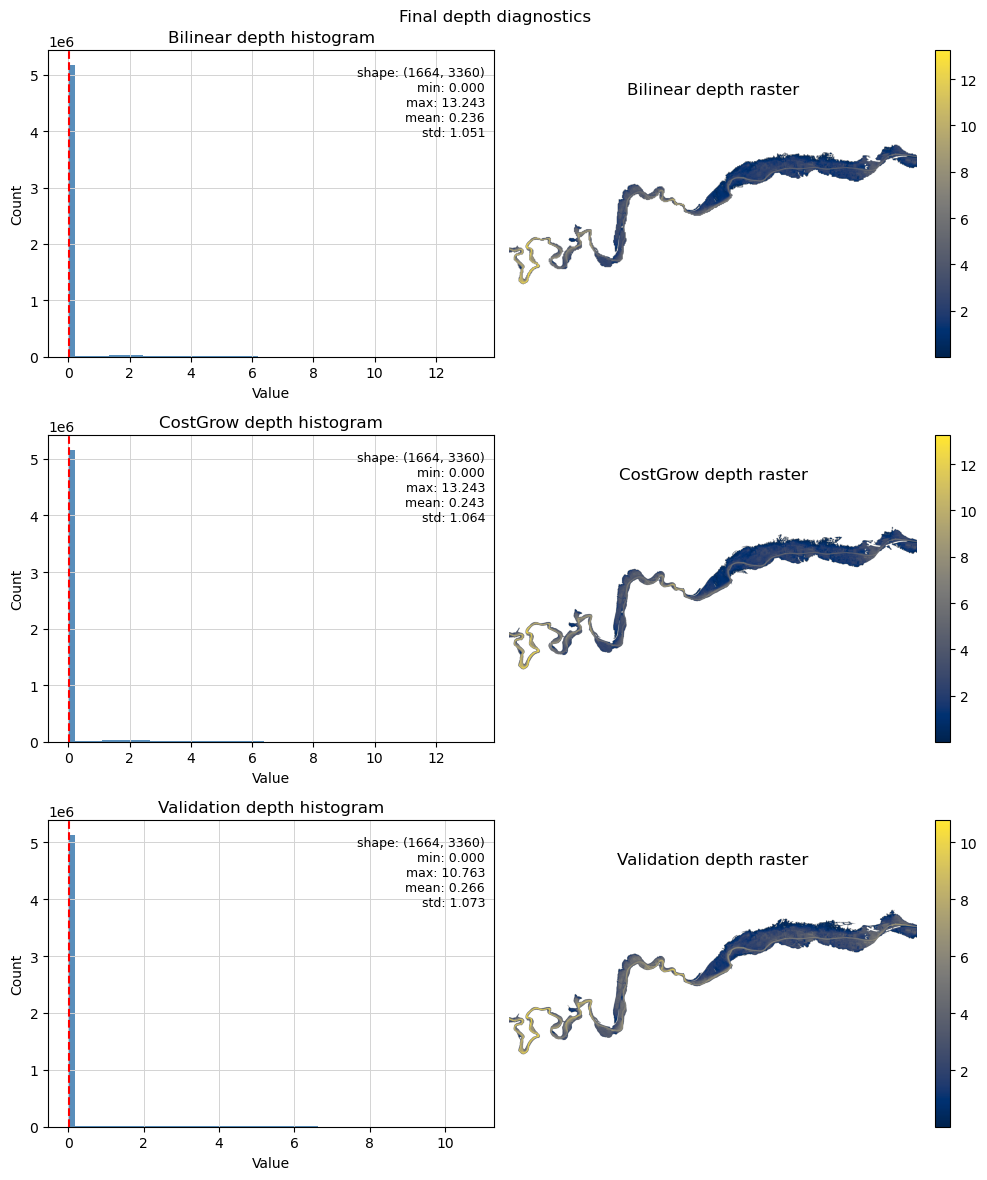

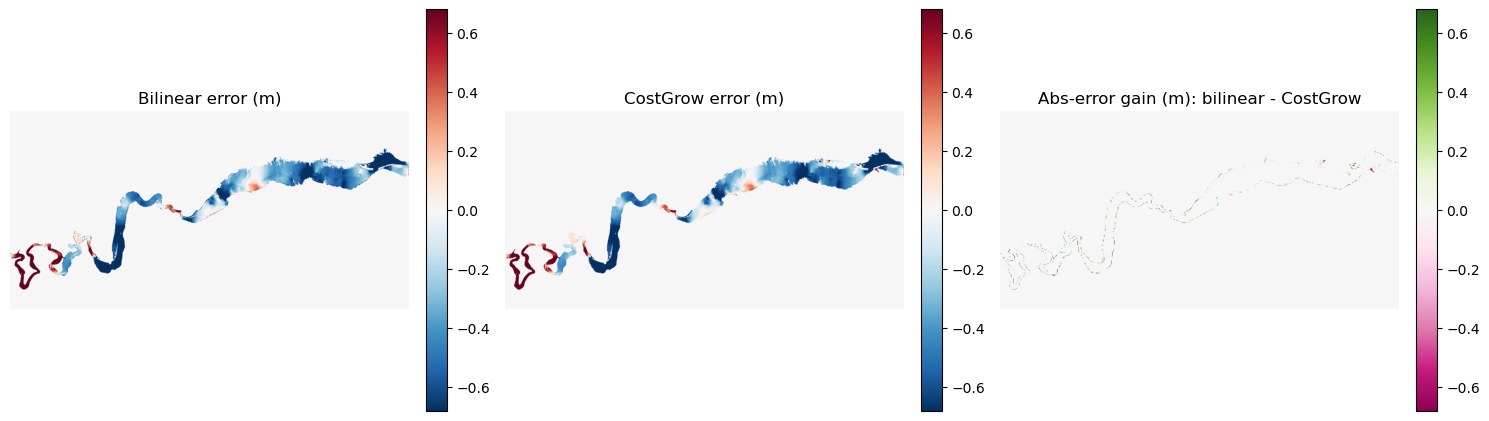

In [18]:
# Inference-style histogram+raster panel for final products in depth units.
plot_specs_final = [
    ("Bilinear depth", bilinear_depth, "cividis", True, DRY_DEPTH_THRESH_M),
    ("CostGrow depth", costgrow_depth, "cividis", True, DRY_DEPTH_THRESH_M),
    ("Validation depth", valid_depth, "cividis", True, DRY_DEPTH_THRESH_M),
]

plot_hist_raster_grid(
    plot_specs=plot_specs_final,
    title="Final depth diagnostics",
    bins=60,
)

# Additional map diagnostics for signed error and absolute-error improvement.
err_bilinear = bilinear_depth - valid_depth
err_costgrow = costgrow_depth - valid_depth
abs_improve = np.abs(err_bilinear) - np.abs(err_costgrow)

valid_err = dem_valid & np.isfinite(err_bilinear) & np.isfinite(err_costgrow)
if np.any(valid_err):
    vmax = float(np.nanpercentile(np.abs(np.r_[err_bilinear[valid_err], err_costgrow[valid_err]]), 98))
    vmax = max(vmax, 1e-6)
else:
    vmax = 1.0

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

im0 = axes[0].imshow(err_bilinear, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
axes[0].set_title("Bilinear error (m)")
axes[0].set_axis_off()
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(err_costgrow, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
axes[1].set_title("CostGrow error (m)")
axes[1].set_axis_off()
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(abs_improve, cmap="PiYG", vmin=-vmax, vmax=vmax)
axes[2].set_title("Abs-error gain (m): bilinear - CostGrow")
axes[2].set_axis_off()
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


## 11) Export Downscaled WSE


In [19]:
# # Write CostGrow WSE prediction to GeoTIFF on the DEM grid.
# out_profile = dem_profile.copy()
# out_profile.update(
#     dtype="float32",
#     count=1,
#     nodata=-9999.0,
#     compress="lzw",
# )

# out_arr = np.where(np.isfinite(wse_costgrow), wse_costgrow, out_profile["nodata"]).astype("float32")
# output_wse_fp.parent.mkdir(parents=True, exist_ok=True)

# with rasterio.open(output_wse_fp, "w", **out_profile) as dst:
#     dst.write(out_arr, 1)

# print(f"Wrote downscaled WSE: {output_wse_fp}")
